In [22]:
%matplotlib inline

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from sklearn.model_selection import train_test_split

In [30]:
#Load the data
trans = pd.read_csv('trans10m.csv')


In [31]:
trans.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,86246,205,7,707,1078778070,12564,2012-03-02,12.0,OZ,1,7.59
1,86246,205,63,6319,107654575,17876,2012-03-02,64.0,OZ,1,1.59
2,86246,205,97,9753,1022027929,0,2012-03-02,1.0,CT,1,5.99
3,86246,205,25,2509,107996777,31373,2012-03-02,16.0,OZ,1,1.99
4,86246,205,55,5555,107684070,32094,2012-03-02,16.0,OZ,2,10.38


In [32]:
data=trans.drop(['chain','dept','category','company','brand','productsize',
                 'productmeasure','purchasequantity','purchaseamount'],axis=1)

In [33]:
data.head()

,id,date
0,86246,2012-03-02
1,86246,2012-03-02
2,86246,2012-03-02
3,86246,2012-03-02
4,86246,2012-03-02


In [ ]:
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = data
transaction_data.head()

summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2016-12-31')

print (summary.head())

bgf = BetaGeoFitterpenalizer_coef=0.0()
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

In [16]:
summary.head()

,frequency,recency,T
id,,,
86246,380.0,417.0,1765.0
86252,367.0,389.0,1765.0
12262064,236.0,480.0,1765.0
12277270,183.0,471.0,1762.0
12332190,112.0,465.0,1762.0


In [21]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf,vmax=0.1)

AttributeError: 'BetaGeoFitter' object has no attribute 'data'

In [14]:
t = 1
data['predicted_purchases'] = data.apply(lambda r: bgf.conditional_expected_number_of_purchases_up_to_time(t, r['x'], r['t_x'], r['T']), axis=1)
data.sort('predicted_purchases').tail(5)

KeyError: ('x', 'occurred at index 0')

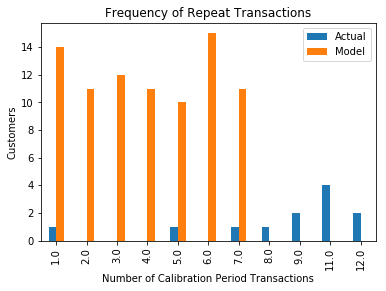

In [9]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [10]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date', 
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )   
print (summary_cal_holdout.head())

ValueError: level name id is not the name of the index

In [ ]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [ ]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# The below function may be renamed to `predict` in a future version of lifetimes
bgf.conditional_expected_number_of_purchases_up_to_time(t, individual['frequency'], individual['recency'], individual['T'])

In [ ]:
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

In [ ]:
#Calculate monetization

In [ ]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())

In [ ]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

In [ ]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

In [ ]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

In [ ]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))